# PACKAGES

In [1]:
import heapq
import networkx as nx
import pandas as pd
import os
from matplotlib import pyplot as plt
import pickle
import numpy as np
from rdkit.Chem import DataStructs
from scipy.ndimage import gaussian_filter1d
from scipy.sparse import csc_matrix
import multiprocessing as mp
from functools import partial
from matplotlib.colors import LinearSegmentedColormap

# INPUTS

In [ ]:
folder_path = 'data/'        
x = pd.read_csv(os.path.join(folder_path, 'x.csv')).values.flatten()  
y = pd.read_csv(os.path.join(folder_path, 'y.csv')).values.flatten()   
s = pd.read_csv(os.path.join(folder_path, 's.csv')).values.flatten()  
t = pd.read_csv(os.path.join(folder_path, 't.csv')).values.flatten()   
with open("data/morgan_fps.pkl", "rb") as f:
    morgan = pickle.load(f)

table_cat = pd.read_csv('data/table_cat.csv',index_col=0, encoding='utf-8')

with open("data/table_num.pkl", "rb") as f:
    obj = pickle.load(f)

table_num = obj["matrix"]
colnames = obj["colnames"]
rownames = obj["rownames"]

/tmp/57729659/ipykernel_1776663/2516668535.py:9: DtypeWarning: Columns (5,10,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  table_cat = pd.read_csv('/work/FAC/FBM/DSB/flanglet/tango-bioinf/David/EDMap_res/1_PAPER_REVISIONS/table_cat.csv',index_col=0, encoding='utf-8')


# FUNCTION

In [6]:
def get_closest_connected_nodes(index, x, y, G, k=50):
    visited = {index}
    heap = []
    result = [index] 
    x0, y0 = x[index], y[index]
    for nbr in G.neighbors(index):
        dx = x[nbr] - x0
        dy = y[nbr] - y0
        dist = dx*dx + dy*dy 
        heapq.heappush(heap, (dist, nbr))
    while heap and len(result) < k + 1:  
        dist, node = heapq.heappop(heap)
        if node in visited:
            continue
        visited.add(node)
        result.append(node)
        for nbr in G.neighbors(node):
            if nbr not in visited:
                dx = x[nbr] - x0
                dy = y[nbr] - y0
                d = dx*dx + dy*dy
                heapq.heappush(heap, (d, nbr))
    return result

def plot_knn(neighbors, x, y, s, t, distance=0.01):
    xaxis = x[neighbors[0]]
    yaxis = y[neighbors[0]]
    xlim = [xaxis - distance, xaxis + distance]
    ylim = [yaxis - distance, yaxis + distance]

    gradient = range(len(neighbors))
    cmap = plt.cm.viridis
    colors = [cmap(i / (len(neighbors) - 1)) for i in gradient]
    fig, ax = plt.subplots(figsize=(10, 10))
    G = nx.Graph()
    G.add_edges_from(zip(s, t))
    for u, v in G.edges():
        if u in neighbors or v in neighbors:
            ax.plot([x[u], x[v]], [y[u], y[v]], color='gray', alpha=0.5)

    ax.scatter(x, y, s=10, color='lightblue', label='All nodes')
    for i, node in enumerate(neighbors):
        ax.scatter(x[node], y[node], color=colors[i], s=50, zorder=5)
        ax.text(x[node], y[node], str(i), fontsize=8, ha='left', va='bottom')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(neighbors)-1))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Order')
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.axis('off')
    plt.show()

def k_similarity_matrix(neighbors, morgan):
    morgan_subset = [morgan[m] for m in neighbors]
    n = len(morgan_subset)
    sim_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            sim_matrix[i, j] = DataStructs.TanimotoSimilarity(morgan_subset[i], morgan_subset[j])
    return sim_matrix

def decay_curve(sim_matrix, sigma=2):
    smoothed = gaussian_filter1d(sim_matrix[0], sigma=sigma)
    plt.figure(figsize=(8, 4))
    plt.plot(smoothed, linewidth=2)
    plt.xlabel('k-NN Index')
    plt.ylabel('Tanimoto Similarity')
    plt.show()

def process_row(row_data, G, depth):
    idx, row, iteration_number = row_data
    target_index = idx
    # Get connected neighbors using BFS
    connected_neighbors = list(nx.bfs_edges(G, source=target_index, depth_limit=depth))
    connected_nodes = {target_index} | {node for edge in connected_neighbors for node in edge}
    expvalue = row['features']
    # Create subgraph and calculate distances
    subgraph_nodes = list(connected_nodes)
    subgraph = G.subgraph(subgraph_nodes)
    distances = nx.single_source_shortest_path_length(subgraph, target_index)
    max_distance = max(distances.values())
    # Initialize array for this iteration
    values = np.zeros(G.number_of_nodes())
    # Vectorized imputation
    if expvalue > 0:
        for node, dist in distances.items():
            values[node] = expvalue * np.exp(-dist / max_distance)
    else:
        for node, dist in distances.items():
            values[node] = expvalue * np.exp(-dist / max_distance)
    return values

def calculate_imputed_values(depth, index, table_num, features,s,t):
    rownames = features
    column_values = table_num[:, index].toarray().flatten()
    df = pd.DataFrame({'chemicals': rownames, 'features': column_values})
    df_filtered = df[df['features'] != 0]

    G = nx.Graph()
    G.add_edges_from(zip(s, t))
    # Prepare data for parallel processing
    row_data = [(idx, row, df_filtered.index.get_loc(idx) + 1) 
                for idx, row in df_filtered.iterrows()]
    # Initialize the results array
    results = np.zeros((len(df_filtered), len(column_values)))
    # Use parallel processing
    with mp.Pool() as pool:
        process_func = partial(process_row, G=G, depth=depth)
        chunk_size = max(1, len(row_data) // mp.cpu_count())
        
        for i, result in enumerate(pool.imap(process_func, row_data, chunksize=chunk_size)):
            if (i) % 100 == 0:
                print(f"Iteration {i + 1} over {df_filtered.shape[0]}")
            results[i] = result
    print('Calculating mean of imputed values...')
    with np.errstate(divide='ignore', invalid='ignore'):
        nonzero_count = np.count_nonzero(results, axis=0)
        mean_imputed_values = np.where(nonzero_count > 0,np.sum(results, axis=0) / nonzero_count, 0)
    df['features_imputed'] = mean_imputed_values
    df.loc[df['features'] != 0, 'features_imputed'] = df['features']
    return df['features_imputed'].values

def plot_imputed_values(imputed_data,table_cat,x,y,s,t,feature):
    df = pd.DataFrame({
        'Column_Data': imputed_data,
        'Common_Name': table_cat['ID_CommonName'].values,
        'x': x,
        'y': y
    })
    vmin, vmax = df['Column_Data'].min(), df['Column_Data'].max()
    print(f"Value range: min={vmin:.3f}, max={vmax:.3f}")
    colors = [
        (-1.0, "#0a5a64"),
        (0.0, "#ececec"),
        (1.0, "#64140a")
    ]
    custom_cmap = LinearSegmentedColormap.from_list(
        "blue_grey_red",
        [c[1] for c in colors],
        N=256
    )
    fig, ax = plt.subplots(figsize=(12, 12))
    segments = [
        [(x[s[i]], y[s[i]]), (x[t[i]], y[t[i]])]
        for i in range(len(s))
    ]
    scatter = ax.scatter(
        x,
        y,
        zorder=2,
        s=1,
        c=df['Column_Data'],
        cmap=custom_cmap,
        vmin=-1,
        vmax=1
    )
    ax.set_title(feature)
    ax.axis('off')
    plt.colorbar(scatter, ax=ax, label='Value')
    plt.show()


# WORKFLOW

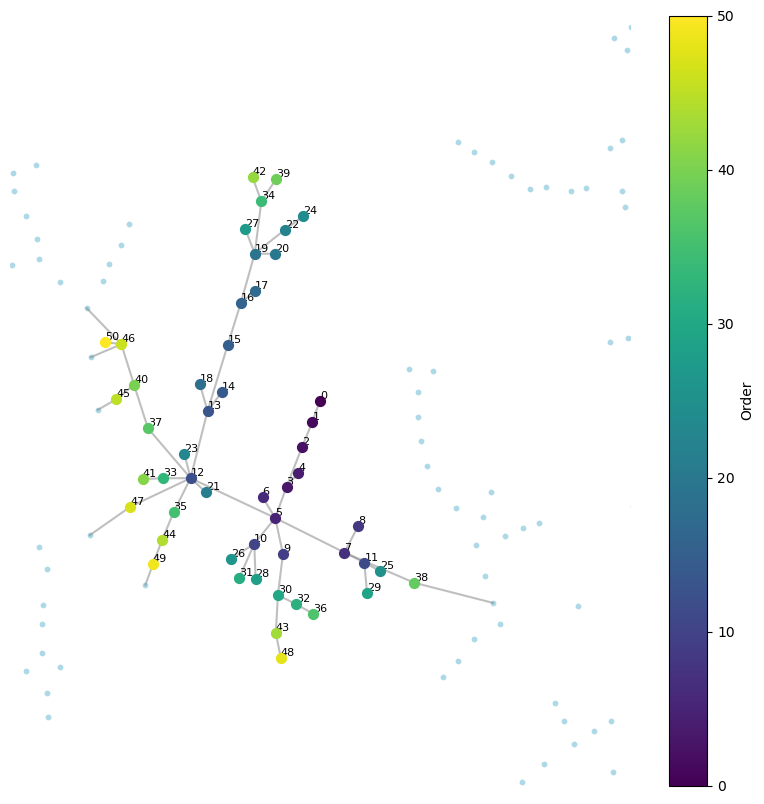

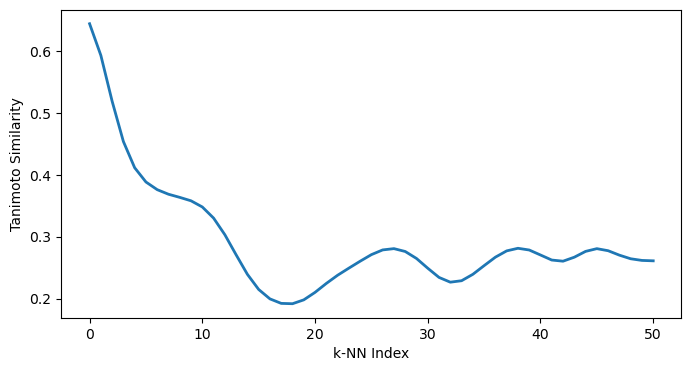

In [7]:
# SET PARAMS
index = 20
k = 50

# FIND AND PLOT THE kNNs
G = nx.Graph()
G.add_edges_from(zip(s, t))
neighbors = get_closest_connected_nodes(index, x, y, G, k)
plot_knn(neighbors, x, y, s, t, distance=0.01)

# COMPUTE SIMILARITY MATRIX AND PRODUCE DECAY CURVE
sim_matrix = k_similarity_matrix(neighbors, morgan)
decay_curve(sim_matrix, sigma=2)


Iteration 1 over 632
Iteration 101 over 632
Iteration 201 over 632
Iteration 301 over 632
Iteration 401 over 632
Iteration 501 over 632
Iteration 601 over 632
Calculating mean of imputed values...
Value range: min=-1.000, max=1.000


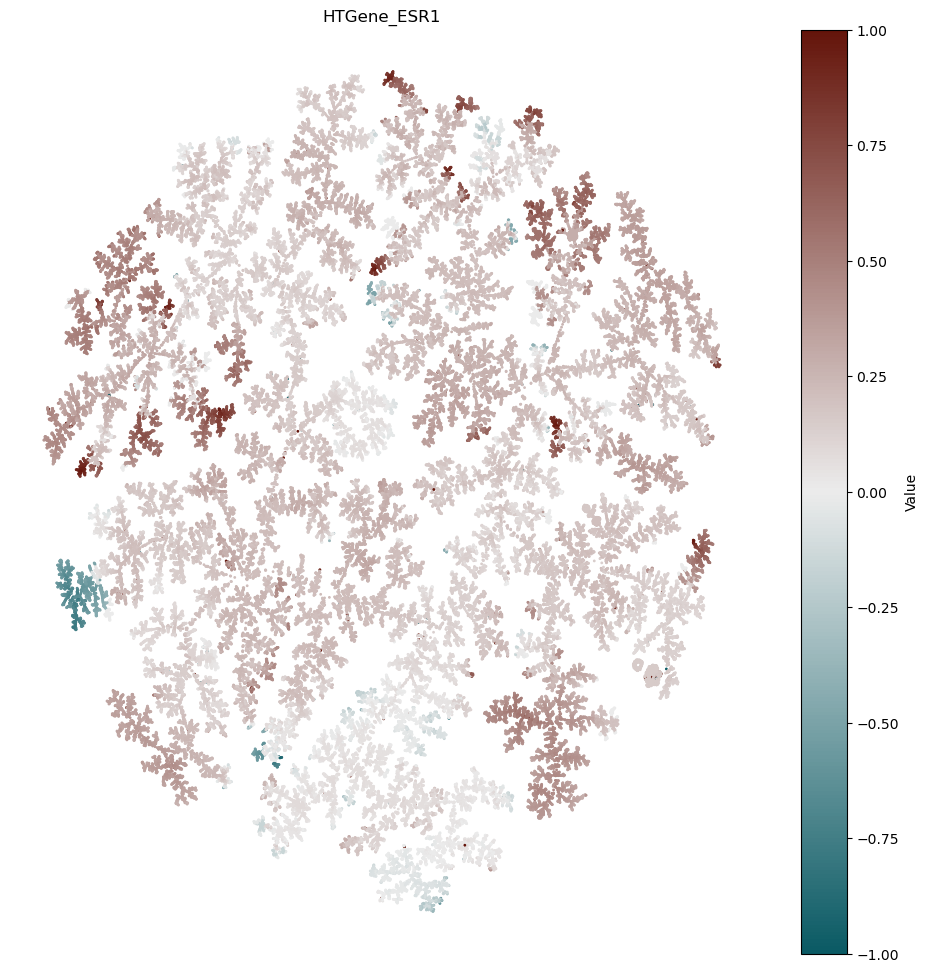

In [8]:
# DATA IMPUTATION AND PLOTTING
feature = 'HTGene_ESR1'
feature_index =  colnames.index(feature)
imputed_data = calculate_imputed_values(depth=50, index=feature_index, table_num=table_num, features=rownames, s=s, t=t)
plot_imputed_values(imputed_data,table_cat,x,y,s,t,feature)